# Rule-Based EMS (Baseline Controller)

This notebook demonstrates a transparent, heuristic Energy Management System (EMS).

We run **three independent scenarios**:

1. **Sunny Day, Grid Connected** — normal operation.
2. **Night Islanding** — grid is disconnected at night (islanded microgrid).
3. **Expensive Grid Imports** — higher grid import tariff to stress local generation & storage.

For each scenario, we build the microgrid, run the EMS-driven simulation.


In [1]:
import sys, os, importlib
import numpy as np
import pandas as pd

# Path setup so we can `import microgrid_sim` from the repo root
project_root = os.path.abspath(os.path.join(os.getcwd(), '..'))
if project_root not in sys.path:
    sys.path.append(project_root)
print("Using project_root:", project_root)

Using project_root: c:\Users\olanr\Downloads\course-proj\microgrid-control-sim


In [2]:
from microgrid_sim.core import MicrogridEnv
from microgrid_sim.components.generators import PVGenerator, WindTurbine, FossilGenerator, GridIntertie
from microgrid_sim.components.storage import BatteryStorage
from microgrid_sim.components.loads import ResidentialLoad, FactoryLoad

from microgrid_sim.control import RuleBasedEMS
from microgrid_sim.control.rules import (
    BatteryRule, DieselRule, GridRule,
    RenewableDisconnectRule, TimeSchedule, SetpointSchedule
)

from microgrid_sim.utils import plot_simulation
from microgrid_sim.data import SyntheticDataBuilder

# Reload modules for iterative development in notebooks
importlib.reload(sys.modules['microgrid_sim.core'])
importlib.reload(sys.modules['microgrid_sim.control'])
importlib.reload(sys.modules['microgrid_sim.control.ems_rule'])
importlib.reload(sys.modules['microgrid_sim.control.rules'])
importlib.reload(sys.modules['microgrid_sim.utils.data_loader'])

print("Imports OK")

Imports OK


## General Constants

In [3]:

## General Constants
total_hours = 24 * 7
control_dt = 60       # EMS decisions are made every 60 minutes
sim_dt = 60            # Physics are simulated every 1 minute
dt_hours = sim_dt / 60.0

## Data Generation

In [4]:
# Component Definitions (Shared by all Scenarios)
pv = PVGenerator("pv", capacity_kw=5.0, time_step_minutes=sim_dt, derate=0.9)
wind = WindTurbine("wind", rated_kw=8.5, time_step_minutes=sim_dt)
diesel = FossilGenerator("diesel", p_min_kw=0.0, p_max_kw=15.0, time_step_minutes=sim_dt, fuel_cost_per_kwh=0.25)

house1 = ResidentialLoad("house1", base_kw=1.5, noise_std=0.0) # Noise is in the data
house2 = ResidentialLoad("house2", base_kw=1.2, noise_std=0.0)
house3 = ResidentialLoad("house3", base_kw=1.8, noise_std=0.0)
factory = FactoryLoad("factory", base_kw=4.0, noise_std=0.0)

bat = BatteryStorage(
    "bat", capacity_kwh=50.0, time_step_minutes=sim_dt, initial_soc=0.5,
    min_soc=0.1, max_soc=0.9, max_charge_kw=8.0, max_discharge_kw=8.0,
    charge_efficiency=0.95, discharge_efficiency=0.95, degradation_cost_per_kwh=0.01
)
grid = GridIntertie("grid", time_step_minutes=sim_dt, price_import_per_kwh=0.20, price_export_per_kwh=0.05)

# Initialize the builder
data_builder = SyntheticDataBuilder(total_hours=total_hours, sim_dt_minutes=sim_dt, seed=1)

# 2. Add components (this creates smooth, interpolated data)
data_builder.add_pv(pv.name, peak_irr=900, noise_std_dev=0.03)
data_builder.add_wind(wind.name, mean_speed=6.0, noise_std_dev=0.05)
data_builder.add_load(factory.name, base_kw=10.0, profile="factory", noise_std_dev=0.05)
data_builder.add_load(house1.name, base_kw=1.5, profile="residential", noise_std_dev=0.1)
data_builder.add_load(house2.name, base_kw=1.2, profile="residential", noise_std_dev=0.1)
data_builder.add_load(house3.name, base_kw=1.8, profile="residential", noise_std_dev=0.1)
data_builder.add_grid_prices(
    name=grid.name,
    peak_import_price=0.30,   # High price 4pm-8pm
    offpeak_import_price=0.10, # Low price all other times
    peak_export_price=0.08,
    offpeak_export_price=0.05
)

# This is the high-fidelity, per-minute exogenous data
exog_list = data_builder.build_list()

print(f"Built {len(exog_list)} steps of high-fidelity (interpolated) exogenous data.")

Built 168 steps of high-fidelity (interpolated) exogenous data.


## Scenario 1 — Sunny Day, Grid Connected

Running Scenario 1: Sunny Day (Grid Connected)...


Scenario 1 Total Cost: $-80.86
Scenario 1 Unmet Energy (kWh): 0.00


,pv_power,pv_cost,pv_downtime,wind_power,wind_cost,wind_downtime,diesel_power,diesel_cost,diesel_downtime,grid_power,...,gen_total_kw,load_total_kw,storage_total_kw,grid_slack_kw,net_power_unbalanced,unmet_load_kw,curtailed_gen_kw,downtime,total_cashflow,t
step (sim_dt),,,,,,,,,,,,,,,,,,,,,
163,0.000000,0.0,0.0,0.742029,0.0,0.0,0.0,0.0,0.0,-4.246549,...,0.742029,-2.49548,6.0,-4.246549,4.246549,0.0,0.0,0.0,0.272470,163.0
164,0.045702,0.0,0.0,0.650720,0.0,0.0,4.0,-1.0,0.0,-8.200942,...,4.696422,-2.49548,6.0,-8.200942,8.200942,0.0,0.0,0.0,-0.417932,164.0
165,0.094402,0.0,0.0,0.148170,0.0,0.0,4.0,-1.0,0.0,-7.747092,...,4.242572,-2.49548,6.0,-7.747092,7.747092,0.0,0.0,0.0,-0.655325,165.0
166,0.035331,0.0,0.0,0.130554,0.0,0.0,4.0,-1.0,0.0,-1.670406,...,4.165886,-2.49548,0.0,-1.670406,1.670406,0.0,0.0,0.0,-0.912745,166.0
167,0.011549,0.0,0.0,0.064519,0.0,0.0,4.0,-1.0,0.0,-1.580588,...,4.076068,-2.49548,0.0,-1.580588,1.580588,0.0,0.0,0.0,-0.917437,167.0


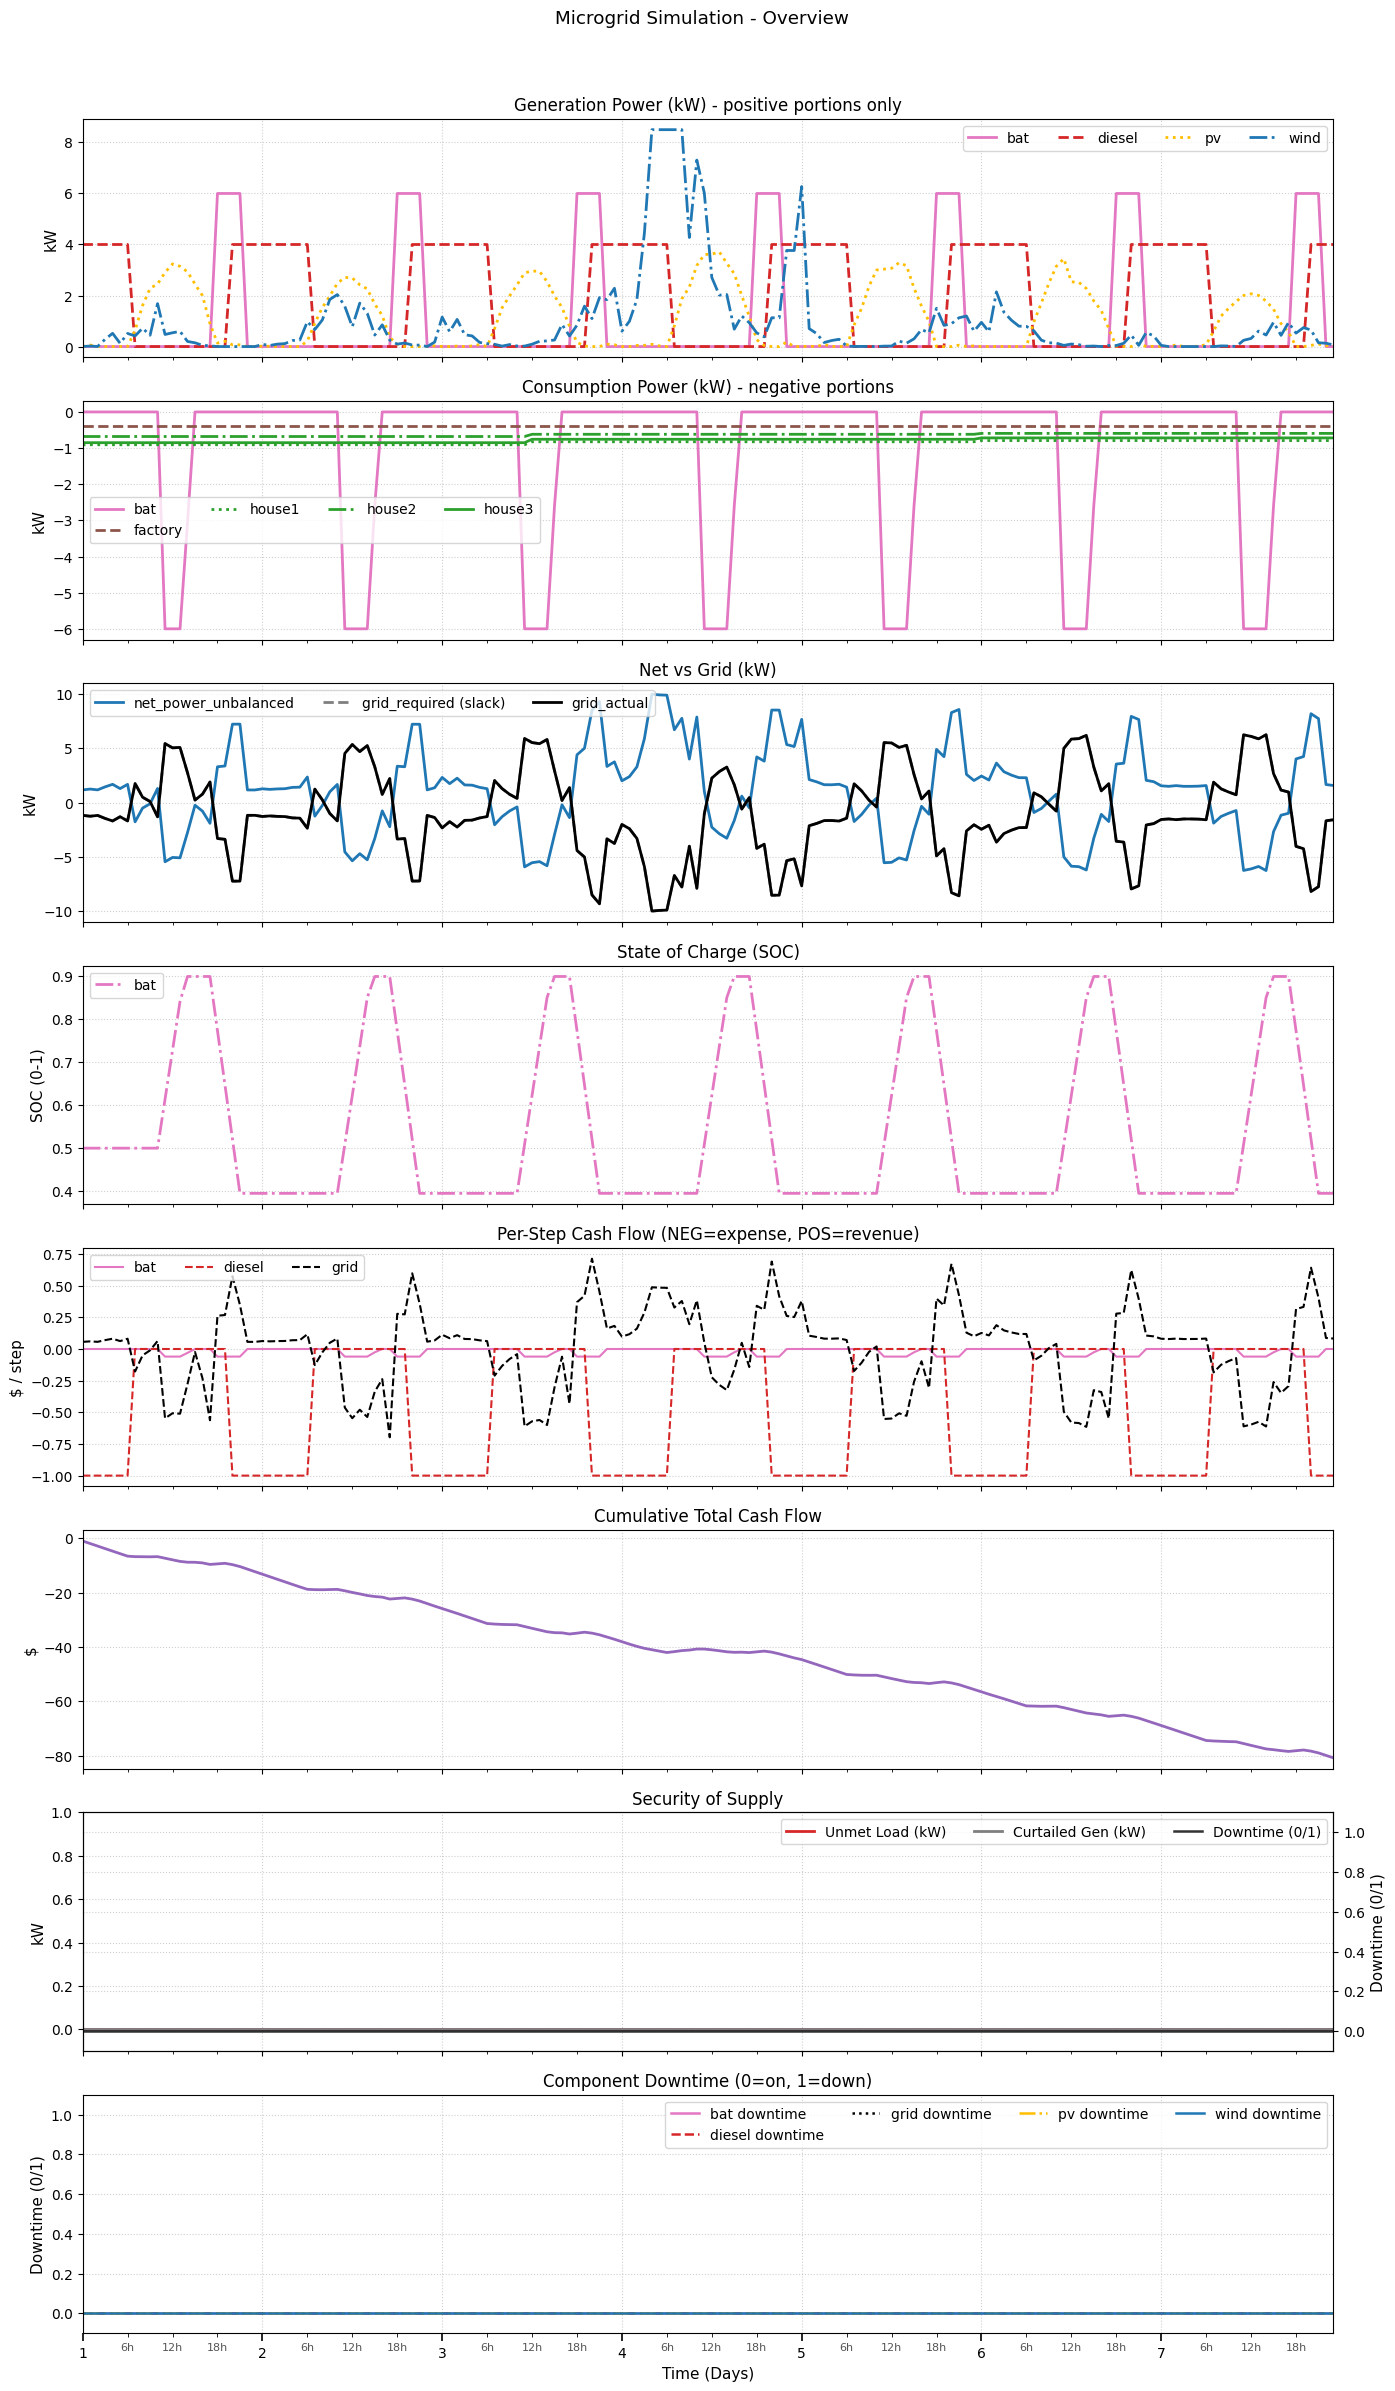

In [5]:
# Build Environment
env1 = MicrogridEnv(
    simulation_hours=total_hours,
    control_interval_minutes=control_dt,
    sim_dt_minutes=sim_dt
)

for c in (pv, wind, diesel, house1, house2, house3, factory, bat):
    env1.add_component(c)
env1.add_component(grid, is_grid=True)

# Define Controller
rules_s1 = [
    BatteryRule(
        name=bat.name,
        charge_schedule=TimeSchedule(11, 15),
        discharge_schedule=TimeSchedule(18, 21)
    ),
    DieselRule(
        name=diesel.name,
        run_schedule=TimeSchedule(20, 6),
        setpoint_kw=4.0
    ),
    GridRule(name=grid.name), # Default: no islanding, no setpoints
    RenewableDisconnectRule(name=pv.name), # Default: no disconnect
    RenewableDisconnectRule(name=wind.name) # Default: no disconnect
]
ems1 = RuleBasedEMS(rules=rules_s1)

# Run Online Simulation Loop
print("Running Scenario 1: Sunny Day (Grid Connected)...")

env1.run(controller=ems1, exogenous_list=exog_list)

# Get Results and Plot
df1 = env1.get_results()
_ = plot_simulation(df1, actions=None, sim_dt_minutes=sim_dt, sim_name="03-01_rule_based_sunny_1min", save=True)

# Summary
total_cost_1 = df1["total_cashflow"].sum()
unmet_energy_1 = df1["unmet_load_kw"].sum() * dt_hours
print(f"Scenario 1 Total Cost: ${total_cost_1:.2f}")
print(f"Scenario 1 Unmet Energy (kWh): {unmet_energy_1:.2f}")
df1.tail()

## Scenario 2 — Night Islanding


Running Scenario 2: Night Islanding (hours 10-14)...
Scenario 2 Total Cost: $-74.19
Scenario 2 Unmet Energy (kWh): 5.34


,pv_power,pv_cost,pv_downtime,wind_power,wind_cost,wind_downtime,diesel_power,diesel_cost,diesel_downtime,grid_power,...,gen_total_kw,load_total_kw,storage_total_kw,grid_slack_kw,net_power_unbalanced,unmet_load_kw,curtailed_gen_kw,downtime,total_cashflow,t
step (sim_dt),,,,,,,,,,,,,,,,,,,,,
163,0.000000,0.0,0.0,0.742029,0.0,0.0,0.0,0.0,0.0,1.753451,...,0.742029,-2.49548,0.0,1.753451,-1.753451,0.0,0.000000,0.0,-0.524283,163.0
164,0.045702,0.0,0.0,0.650720,0.0,0.0,2.0,-0.5,0.0,-0.200942,...,2.696422,-2.49548,0.0,-0.200942,0.200942,0.0,0.000000,0.0,-0.484268,164.0
165,0.094402,0.0,0.0,0.148170,0.0,0.0,2.0,-0.5,0.0,0.252908,...,2.242572,-2.49548,0.0,0.252908,-0.252908,0.0,0.000000,0.0,-0.524717,165.0
166,0.035331,0.0,0.0,0.130554,0.0,0.0,2.0,-0.5,0.0,0.000000,...,2.165886,-2.49548,6.0,0.000000,5.670406,0.0,5.670406,0.0,-0.560000,166.0
167,0.011549,0.0,0.0,0.064519,0.0,0.0,2.0,-0.5,0.0,0.000000,...,2.076068,-2.49548,6.0,0.000000,5.580588,0.0,5.580588,0.0,-0.560000,167.0


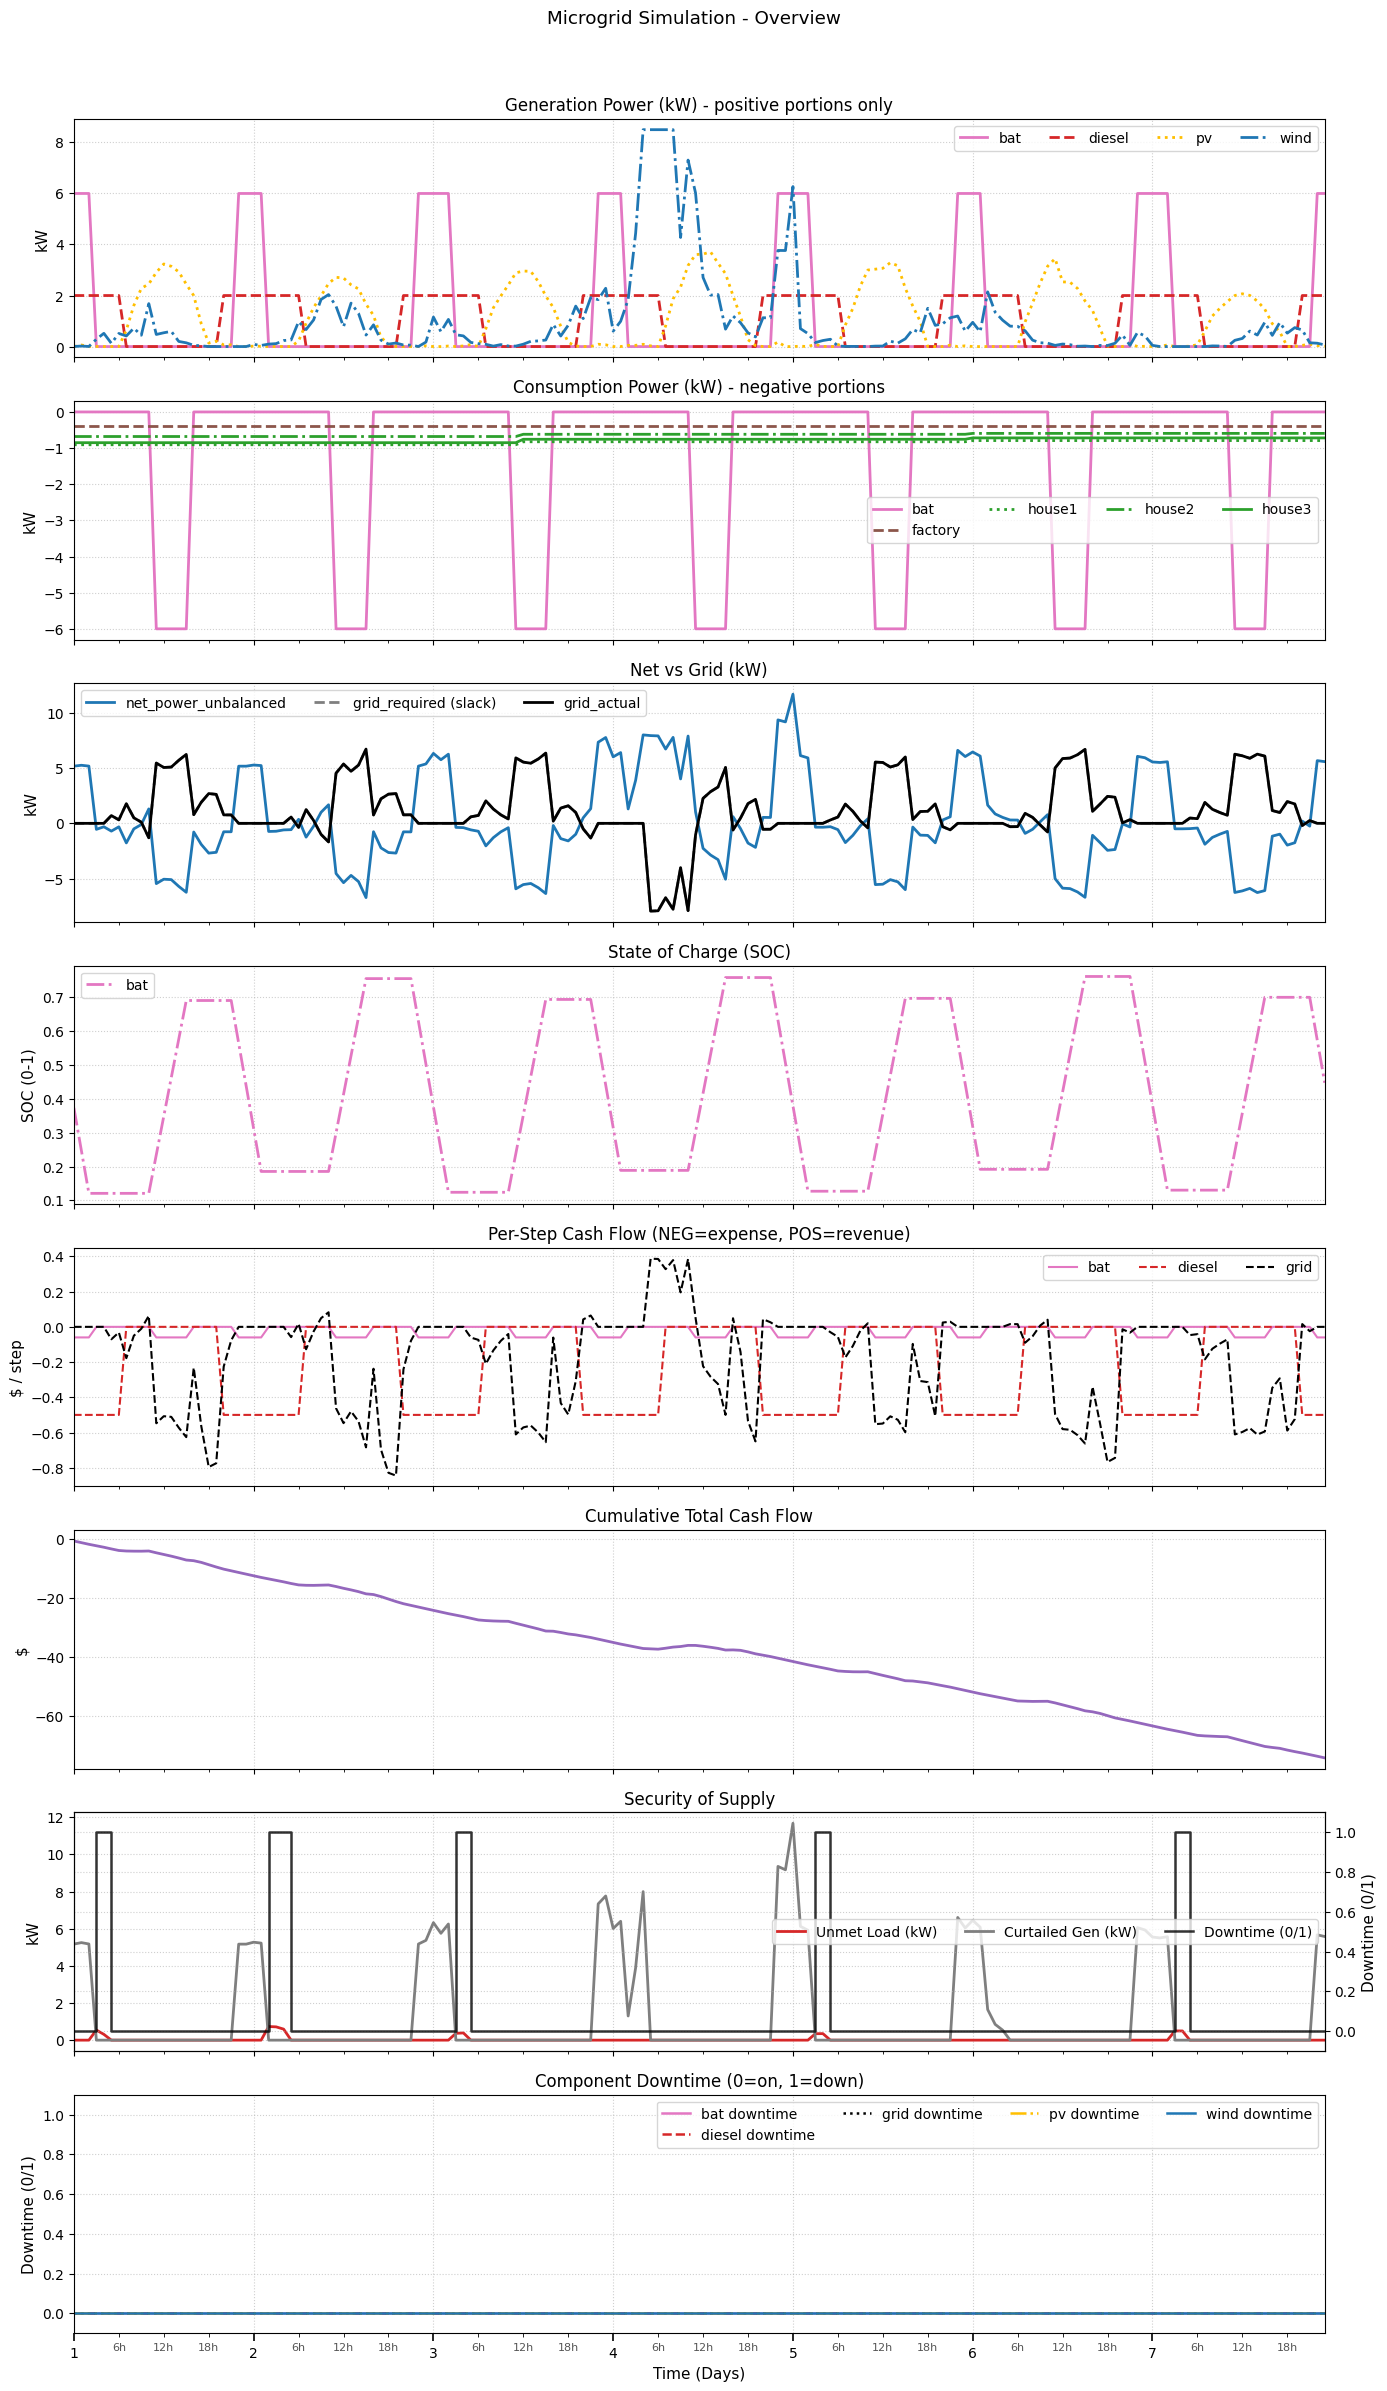

In [6]:
## Scenario 2 — Midday Islanding

# Build Environment
env2 = MicrogridEnv(
    simulation_hours=total_hours,
    control_interval_minutes=control_dt,
    sim_dt_minutes=sim_dt
)

# Add components (they were already reset by env1.reset())
for c in (pv, wind, diesel, house1, house2, house3, factory, bat):
    env2.add_component(c)
env2.add_component(grid, is_grid=True)

# Controller Design
rules_s2 = [
    BatteryRule(
        name=bat.name,
        charge_schedule=TimeSchedule(11, 15),
        discharge_schedule=TimeSchedule(22, 4)
    ),
    DieselRule(
        name=diesel.name,
        run_schedule=TimeSchedule(20, 6),
        setpoint_kw=2.0
    ),
    GridRule(
        name=grid.name,
        island_schedule=TimeSchedule(22, 4) # Disconnect from 22:00 - 04:59
    ),
    RenewableDisconnectRule(name="pv"),
    RenewableDisconnectRule(name="wind")
]
ems2 = RuleBasedEMS(rules=rules_s2)

# Run Online Simulation Loop
print(f"\nRunning Scenario 2: Night Islanding (hours 10-14)...")

env2.run(controller=ems2, exogenous_list=exog_list)

# Get Results and Plot
df2 = env2.get_results()
_ = plot_simulation(df2, sim_dt_minutes=sim_dt, sim_name="03-02_rule_based_island_1min", save=True)

# Summary
total_cost_2 = df2["total_cashflow"].sum()
unmet_energy_2 = df2["unmet_load_kw"].sum() * dt_hours
print(f"Scenario 2 Total Cost: ${total_cost_2:.2f}")
print(f"Scenario 2 Unmet Energy (kWh): {unmet_energy_2:.2f}")
df2.tail()

## Scenario 3 — Expensive Grid Imports


Running Scenario 3: Expensive Grid (Import=$0.5/kWh)...
Scenario 3 Total Cost: $-211.21
Scenario 3 Unmet Energy (kWh): 0.00


,pv_power,pv_cost,pv_downtime,wind_power,wind_cost,wind_downtime,diesel_power,diesel_cost,diesel_downtime,grid_exp_power,...,gen_total_kw,load_total_kw,storage_total_kw,grid_slack_kw,net_power_unbalanced,unmet_load_kw,curtailed_gen_kw,downtime,total_cashflow,t
step (sim_dt),,,,,,,,,,,,,,,,,,,,,
163,0.000000,0.0,0.0,0.742029,0.0,0.0,0.0,0.0,0.0,1.753451,...,0.742029,-2.49548,0.0,1.753451,-1.753451,0.0,0.0,0.0,-0.876726,163.0
164,0.045702,0.0,0.0,0.650720,0.0,0.0,4.0,-1.0,0.0,-8.200942,...,4.696422,-2.49548,6.0,-8.200942,8.200942,0.0,0.0,0.0,-0.649953,164.0
165,0.094402,0.0,0.0,0.148170,0.0,0.0,4.0,-1.0,0.0,-7.747092,...,4.242572,-2.49548,6.0,-7.747092,7.747092,0.0,0.0,0.0,-0.672645,165.0
166,0.035331,0.0,0.0,0.130554,0.0,0.0,4.0,-1.0,0.0,-7.670406,...,4.165886,-2.49548,6.0,-7.670406,7.670406,0.0,0.0,0.0,-0.676480,166.0
167,0.011549,0.0,0.0,0.064519,0.0,0.0,4.0,-1.0,0.0,-7.580588,...,4.076068,-2.49548,6.0,-7.580588,7.580588,0.0,0.0,0.0,-0.680971,167.0


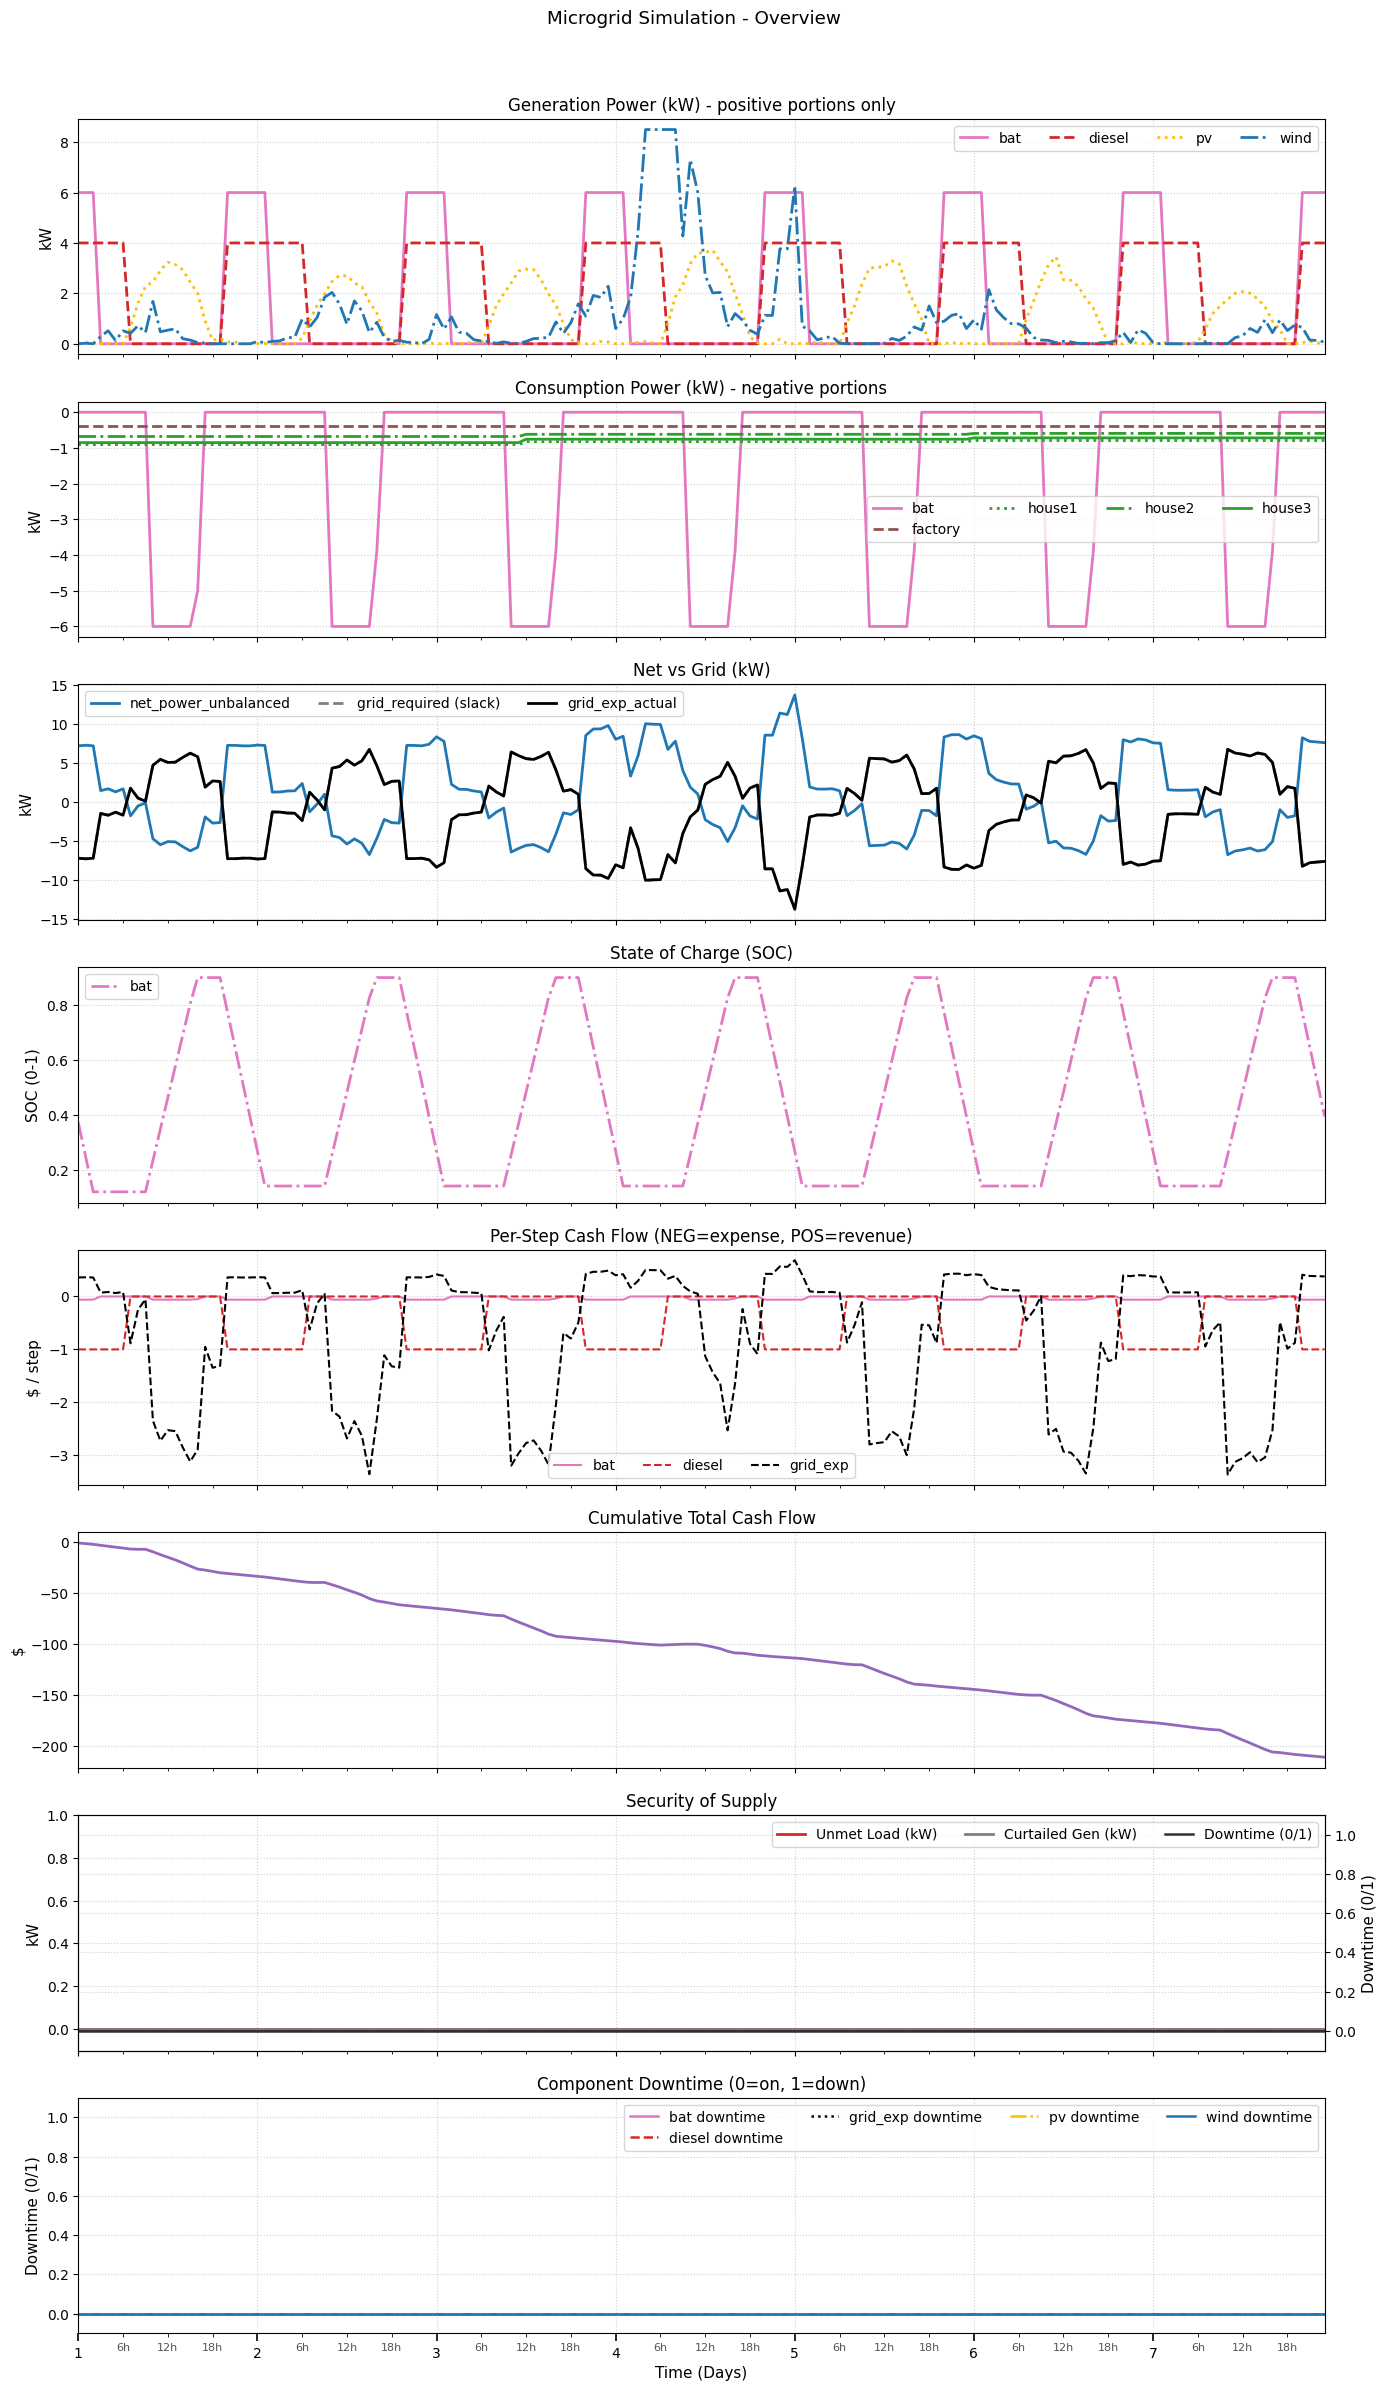

In [7]:
# Define New Grid Component (use sim_dt=1)
grid_expensive = GridIntertie("grid_exp", time_step_minutes=sim_dt,
                            price_import_per_kwh=0.50, # 2.5x more expensive
                            price_export_per_kwh=0.05)

# Build Environment
env3 = MicrogridEnv(
    simulation_hours=total_hours,
    control_interval_minutes=control_dt,
    sim_dt_minutes=sim_dt
)

# Add all standard components
for c in (pv, wind, diesel, house1, house2, house3, factory, bat):
    env3.add_component(c)
env3.add_component(grid_expensive, is_grid=True)

rules_s3 = [
    BatteryRule(name=bat.name),
    DieselRule(name=diesel.name),
    GridRule(name=grid_expensive.name),
    RenewableDisconnectRule(name=pv.name),
    RenewableDisconnectRule(name=wind.name)
]
ems3 = RuleBasedEMS(rules=rules_s3)

# Run Online Simulation Loop
print(f"\nRunning Scenario 3: Expensive Grid (Import=${grid_expensive.params.price_import_per_kwh}/kWh)...")

env3.run(controller=ems3, exogenous_list=exog_list)

# Get Results and Plot
df3 = env3.get_results()
_ = plot_simulation(df3, sim_dt_minutes=sim_dt, sim_name="03-03_rule_based_expensive_1min", save=True)

# Summary
total_cost_3 = df3["total_cashflow"].sum()
unmet_energy_3 = df3["unmet_load_kw"].sum() * dt_hours
print(f"Scenario 3 Total Cost: ${total_cost_3:.2f}")
print(f"Scenario 3 Unmet Energy (kWh): {unmet_energy_3:.2f}")
df3.tail()

## Scenario 4 - Scheduled Grid Buy


Running Scenario 4: Scheduled Grid Buy (8kW from 02:00-04:59)...
Scenario 4 Total Cost: $-102.37
Scenario 4 Unmet Energy (kWh): 0.00


,pv_power,pv_cost,pv_downtime,wind_power,wind_cost,wind_downtime,diesel_power,diesel_cost,diesel_downtime,grid_power,...,gen_total_kw,load_total_kw,storage_total_kw,grid_slack_kw,net_power_unbalanced,unmet_load_kw,curtailed_gen_kw,downtime,total_cashflow,t
step (sim_dt),,,,,,,,,,,,,,,,,,,,,
163,0.000000,0.0,0.0,0.742029,0.0,0.0,0.0,0.0,0.0,1.753451,...,0.742029,-2.49548,0.0,1.753451,-1.753451,0.0,0.0,0.0,-0.524283,163.0
164,0.045702,0.0,0.0,0.650720,0.0,0.0,4.0,-1.0,0.0,-8.200942,...,4.696422,-2.49548,6.0,-8.200942,8.200942,0.0,0.0,0.0,-0.417932,164.0
165,0.094402,0.0,0.0,0.148170,0.0,0.0,4.0,-1.0,0.0,-7.747092,...,4.242572,-2.49548,6.0,-7.747092,7.747092,0.0,0.0,0.0,-0.655325,165.0
166,0.035331,0.0,0.0,0.130554,0.0,0.0,4.0,-1.0,0.0,-7.670406,...,4.165886,-2.49548,6.0,-7.670406,7.670406,0.0,0.0,0.0,-0.659330,166.0
167,0.011549,0.0,0.0,0.064519,0.0,0.0,4.0,-1.0,0.0,-7.580588,...,4.076068,-2.49548,6.0,-7.580588,7.580588,0.0,0.0,0.0,-0.664022,167.0


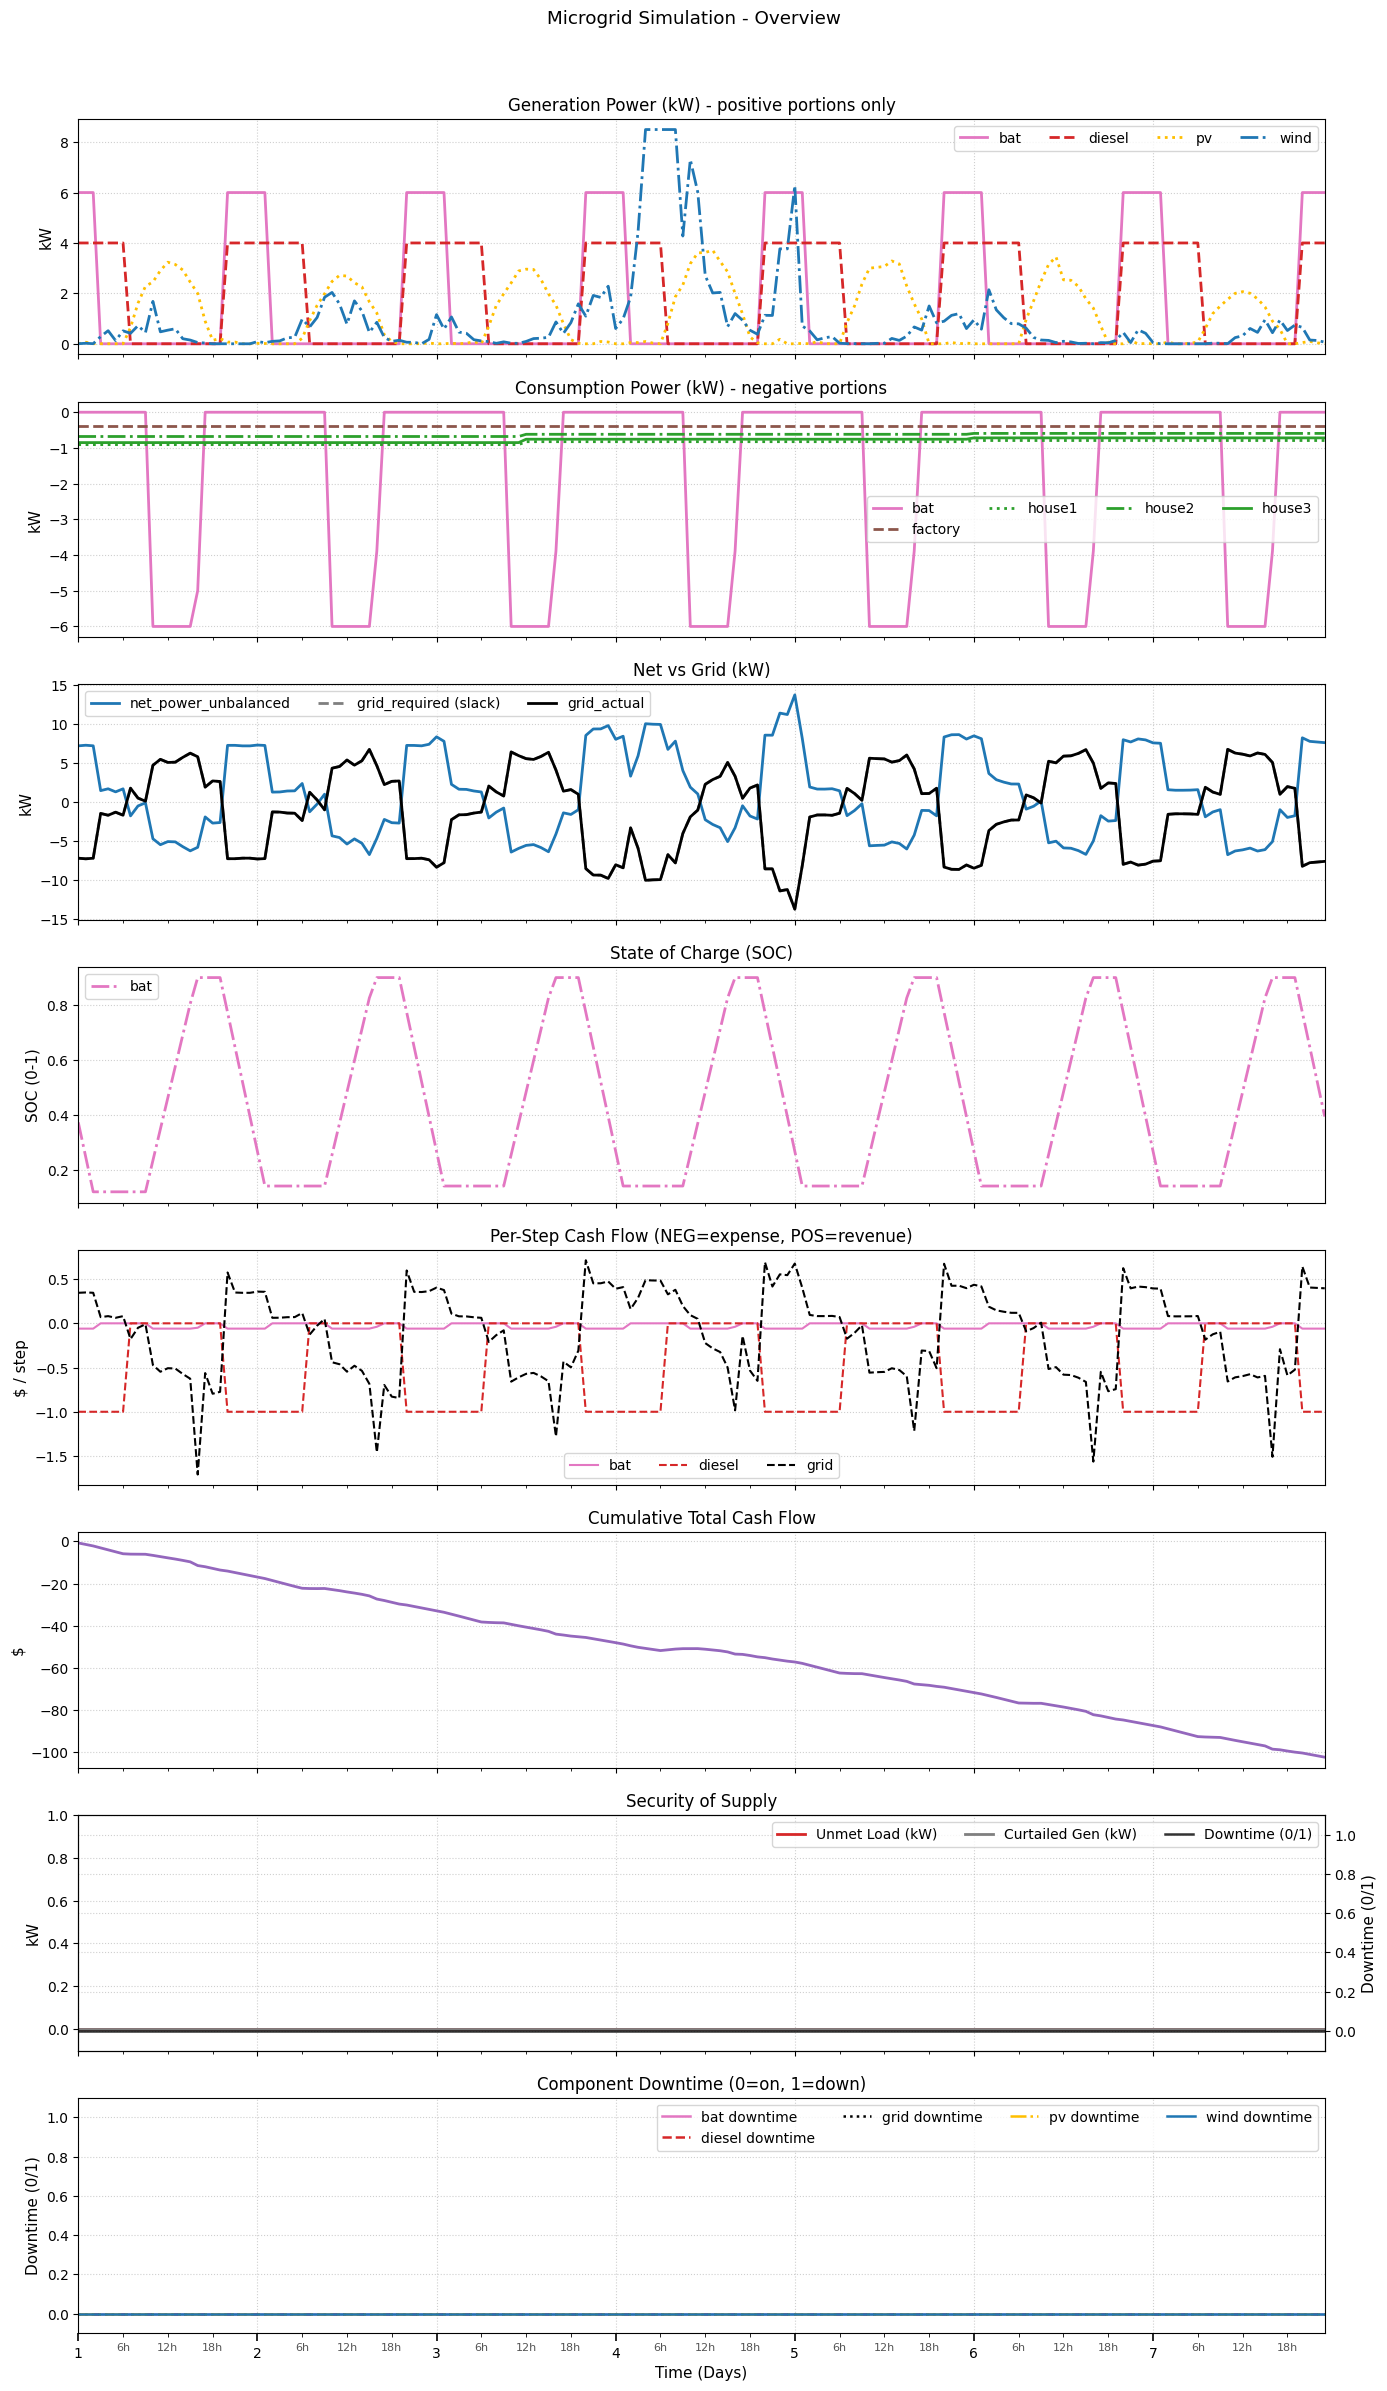

In [8]:
rules_s4 = [
    BatteryRule(name="bat"),
    DieselRule(name="diesel"),
    GridRule(
        name="grid",
        setpoint_schedule=SetpointSchedule(
            start_hour=2,
            end_hour=4,
            setpoint_kw=-8.0
        )
    ),
    RenewableDisconnectRule(name="pv"),
    RenewableDisconnectRule(name="wind")
]
ems4 = RuleBasedEMS(rules=rules_s4)

print(f"\nRunning Scenario 4: Scheduled Grid Buy (8kW from 02:00-04:59)...")
# We can re-use env1 for this, as it has the standard grid
env1.run(controller=ems4, exogenous_list=exog_list)

# Get Results and Plot
df4 = env1.get_results()
_ = plot_simulation(df4, sim_dt_minutes=sim_dt, sim_name="03-04_scheduled_buy_1min", save=True)

# Summary
total_cost_4 = df4["total_cashflow"].sum()
unmet_energy_4 = df4["unmet_load_kw"].sum() * dt_hours
print(f"Scenario 4 Total Cost: ${total_cost_4:.2f}")
print(f"Scenario 4 Unmet Energy (kWh): {unmet_energy_4:.2f}")
df4.tail()